In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gd
import juliet
import multiprocessing
multiprocessing.set_start_method('fork')

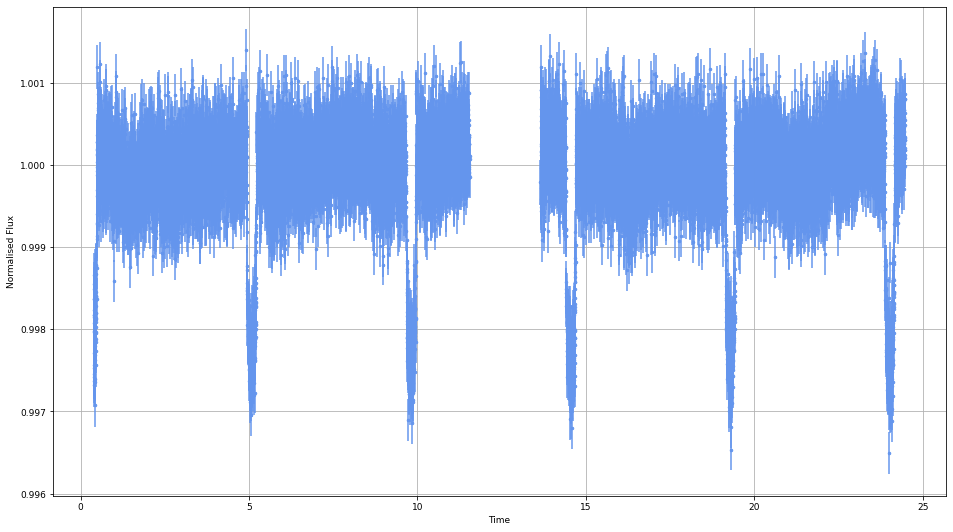

In [2]:
tim, fl, fle = {}, {}, {}
tim['visit1'], fl['visit1'], fle['visit1'] = np.loadtxt('kelt11_1.dat', usecols=(0,1,2), unpack=True)

# Let's see the data
plt.figure(figsize=(16,9))
plt.errorbar(tim['visit1'], fl['visit1'], yerr=fle['visit1'], fmt='.', c='cornflowerblue')
plt.xlabel('Time')
plt.ylabel('Normalised Flux')
plt.grid()

In [3]:
# Instrumental parameters
params_ins = ['mdilution_visit1', 'mflux_visit1', 'sigma_w_visit1']
dist_ins = ['uniform', 'normal', 'loguniform']
hyper_ins = [[0., 1.], [0., 0.1], [0.1, 10000.]]

# GP Params
params_gp = ['GP_sigma_visit1', 'GP_timescale_visit1', 'GP_rho_visit1']
dist_gp = ['loguniform', 'loguniform', 'loguniform']
hyper_gp = [[1e-5, 10000.], [1e-3, 1e2], [1e-3, 1e2]]

params_P = ['P_p1', 't0_p1', 'p_p1_visit1', 'b_p1', 'q1_visit1', 'q2_visit1', 'ecc_p1', 'omega_p1', 'a_p1']
dist_P = ['fixed', 'normal', 'normal', 'normal', 'uniform', 'uniform', 'fixed', 'fixed', 'normal']
hyper_P = [4.7362050, [0.5011, 0.1], [0.04644, 0.001], [0.494, 0.1], [0.,1.], [0.,1.], 0., 90., [4.82, 0.2]]

params = params_ins + params_gp + params_P
dist = dist_ins + dist_gp + dist_P
hyper = hyper_ins + hyper_gp + hyper_P

priors = juliet.utils.generate_priors(params, dist, hyper)

In [4]:
dataset = juliet.load(priors=priors, t_lc=tim, y_lc=fl, yerr_lc=fle, GP_regressors_lc=tim, out_folder='juliet5/')
results = dataset.fit(sampler = 'dynesty', nthreads = 8, verbose=True)

18105it [14:35, 20.67it/s, +500 | bound: 221 | nc: 1 | ncall: 545776 | eff(%):  3.412 | loglstar:   -inf < 103569.254 <    inf | logz: 103533.587 +/-  0.265 | dlogz:  0.001 >  0.509]


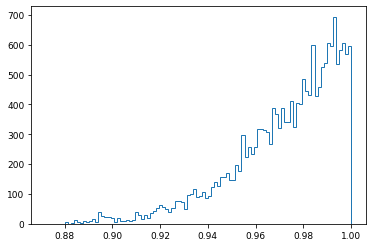

In [5]:
post1 = results.posteriors['posterior_samples']
rprs = post1['mdilution_visit1']
plt.hist(rprs, bins=100, histtype='step');

(0.3872264209203422, 24.480077524203807)

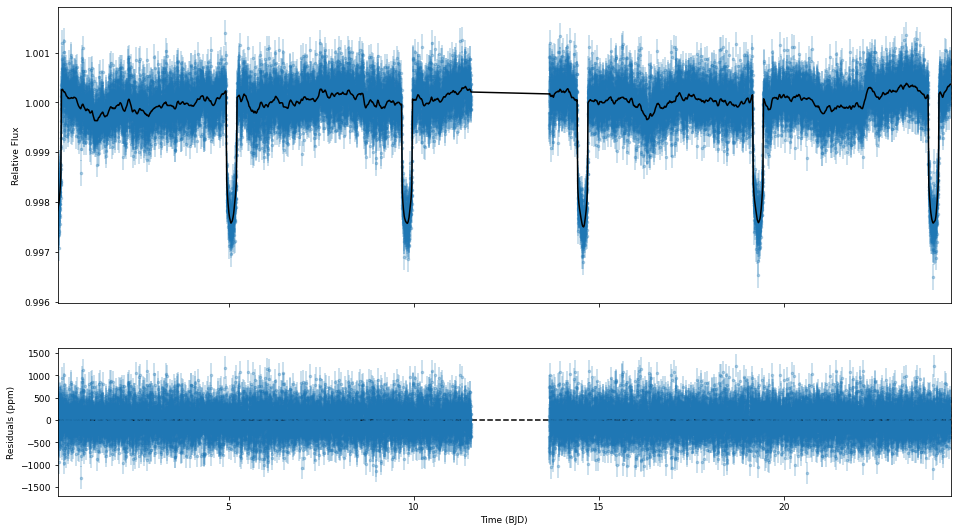

In [6]:
instrument = 'visit1'
# juliet best fit model
model = results.lc.evaluate(instrument)

# Making a plot
fig = plt.figure(figsize=(16,9))
gs = gd.GridSpec(2,1, height_ratios=[2,1])

# Top panel
ax1 = plt.subplot(gs[0])
ax1.errorbar(tim[instrument], fl[instrument], yerr=fle[instrument], fmt='.', alpha=0.3)
ax1.plot(tim[instrument], model, c='k', zorder=100)
ax1.set_ylabel('Relative Flux')
ax1.set_xlim(np.min(tim[instrument]), np.max(tim[instrument]))
ax1.xaxis.set_major_formatter(plt.NullFormatter())

# Bottom panel
ax2 = plt.subplot(gs[1])
ax2.errorbar(tim[instrument], (fl[instrument]-model)*1e6, yerr=fle[instrument]*1e6, fmt='.', alpha=0.3)
ax2.axhline(y=0.0, c='black', ls='--')
ax2.set_ylabel('Residuals (ppm)')
ax2.set_xlabel('Time (BJD)')
ax2.set_xlim(np.min(tim[instrument]), np.max(tim[instrument]))